# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state channel flow (uniform inlet) using Physics-Informed Neural Networks (PINNs).

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
circle = df.geometry.circle(0.2, 0.2, 0.05)
rectangle = df.geometry.rectangle([0,1.1], [0,0.41])
area = rectangle - circle

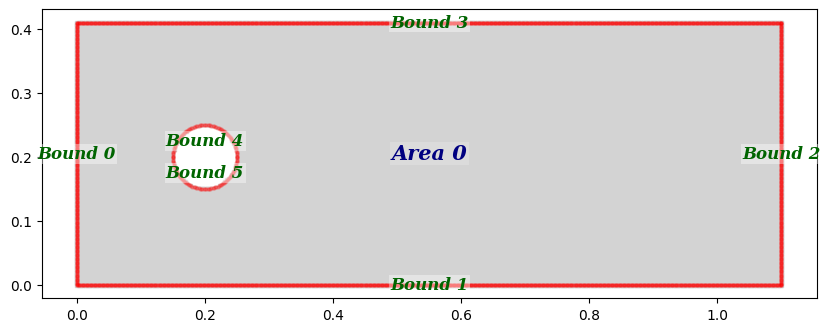

In [3]:
domain = df.domain(area, circle.bound_list)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

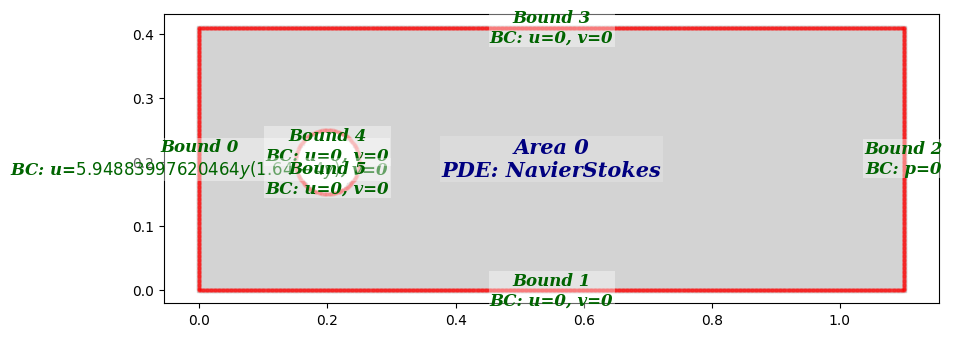

In [4]:
domain.bound_list[0].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'p': 0})
domain.bound_list[3].define_bc({'u': 0,'v': 0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=1, L=1, mu=0.02, rho=1))
domain.show_setup()


Sample initial points for training.

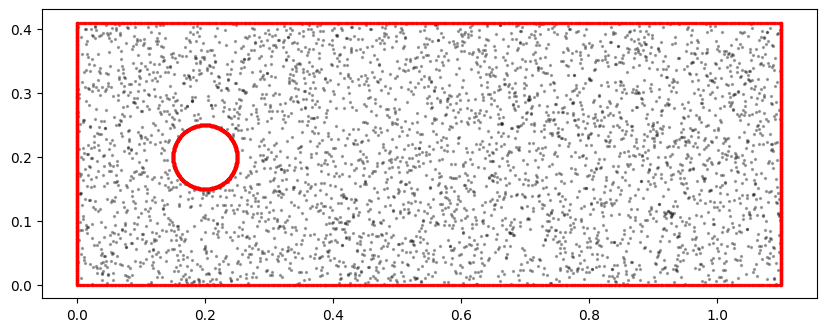

In [5]:
domain.sampling_lhs(bound_sampling_res=[1000, 1000, 1000, 1000, 1000, 1000], area_sampling_res=[4000])
domain.show_coordinates(display_physics=False)

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [6]:
def do_in_adam(epoch, model):
    return
    if epoch % 500 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000, 1000, 1000], area_sampling_res=[4000])
        print(domain)
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000, 1000, 1000], area_sampling_res=[4000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [7]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.004,
    epochs=2000,
    calc_loss=df.calc_loss_simple(domain),
    threshold_loss=0.0005,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 0.73838, bc_loss: 0.73785, pde_loss: 0.00053
Epoch: 200, total_loss: 0.22948, bc_loss: 0.20041, pde_loss: 0.02907
Epoch: 400, total_loss: 0.20793, bc_loss: 0.17884, pde_loss: 0.02909
Epoch: 600, total_loss: 0.19647, bc_loss: 0.17046, pde_loss: 0.02601
Epoch: 800, total_loss: 0.18556, bc_loss: 0.16185, pde_loss: 0.02372
Epoch: 1000, total_loss: 0.17652, bc_loss: 0.15559, pde_loss: 0.02093
Epoch: 1200, total_loss: 0.16480, bc_loss: 0.14278, pde_loss: 0.02201
Epoch: 1400, total_loss: 0.14179, bc_loss: 0.11616, pde_loss: 0.02563
Epoch: 1600, total_loss: 0.12446, bc_loss: 0.10489, pde_loss: 0.01957
Epoch: 1800, total_loss: 0.12884, bc_loss: 0.08950, pde_loss: 0.03934
Epoch: 2000, total_loss: 0.09744, bc_loss: 0.08495, pde_loss: 0.01250


Refine the model using LBFGS for higher precision.

In [8]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=df.calc_loss_simple(domain),
    epochs=450,
    threshold_loss=0.00001,
    do_between_epochs=do_in_lbfgs)

Epoch: 1998, total_loss: 0.09255, bc_loss: 0.07924, pde_loss: 0.01331
Epoch: 2048, total_loss: 0.00355, bc_loss: 0.00119, pde_loss: 0.00236
Epoch: 2098, total_loss: 0.00097, bc_loss: 0.00028, pde_loss: 0.00069
number of bound : ['0: 1489', '1: 1340', '2: 1562', '3: 1395', '4: 1508', '5: 1442']
number of area : ['0: 5134']
Epoch: 2148, total_loss: 0.00090, bc_loss: 0.00024, pde_loss: 0.00066
Epoch: 2198, total_loss: 0.00049, bc_loss: 0.00015, pde_loss: 0.00034
number of bound : ['0: 1852', '1: 1841', '2: 2119', '3: 1787', '4: 1837', '5: 1771']
number of area : ['0: 6258']
Epoch: 2248, total_loss: 0.00049, bc_loss: 0.00012, pde_loss: 0.00037
Epoch: 2298, total_loss: 0.00034, bc_loss: 0.00009, pde_loss: 0.00025
number of bound : ['0: 2106', '1: 2273', '2: 2646', '3: 2233', '4: 2085', '5: 2049']
number of area : ['0: 7192']
Epoch: 2348, total_loss: 0.00041, bc_loss: 0.00010, pde_loss: 0.00031
Epoch: 2398, total_loss: 0.00031, bc_loss: 0.00010, pde_loss: 0.00021
number of bound : ['0: 2324'

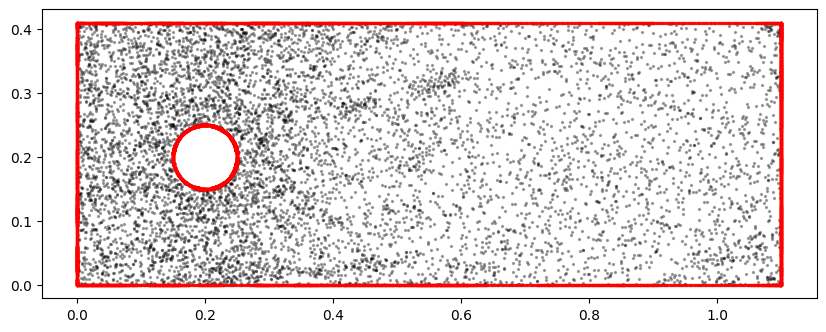

In [9]:
domain.show_coordinates()

Save or Load the model for later use

In [10]:
model2.save_as_pickle()
model2.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [11]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([300, 150])

In [12]:
area_eval["velocity_magnitude"] = (area_eval["u"]**2 + area_eval["v"]**2)**0.5

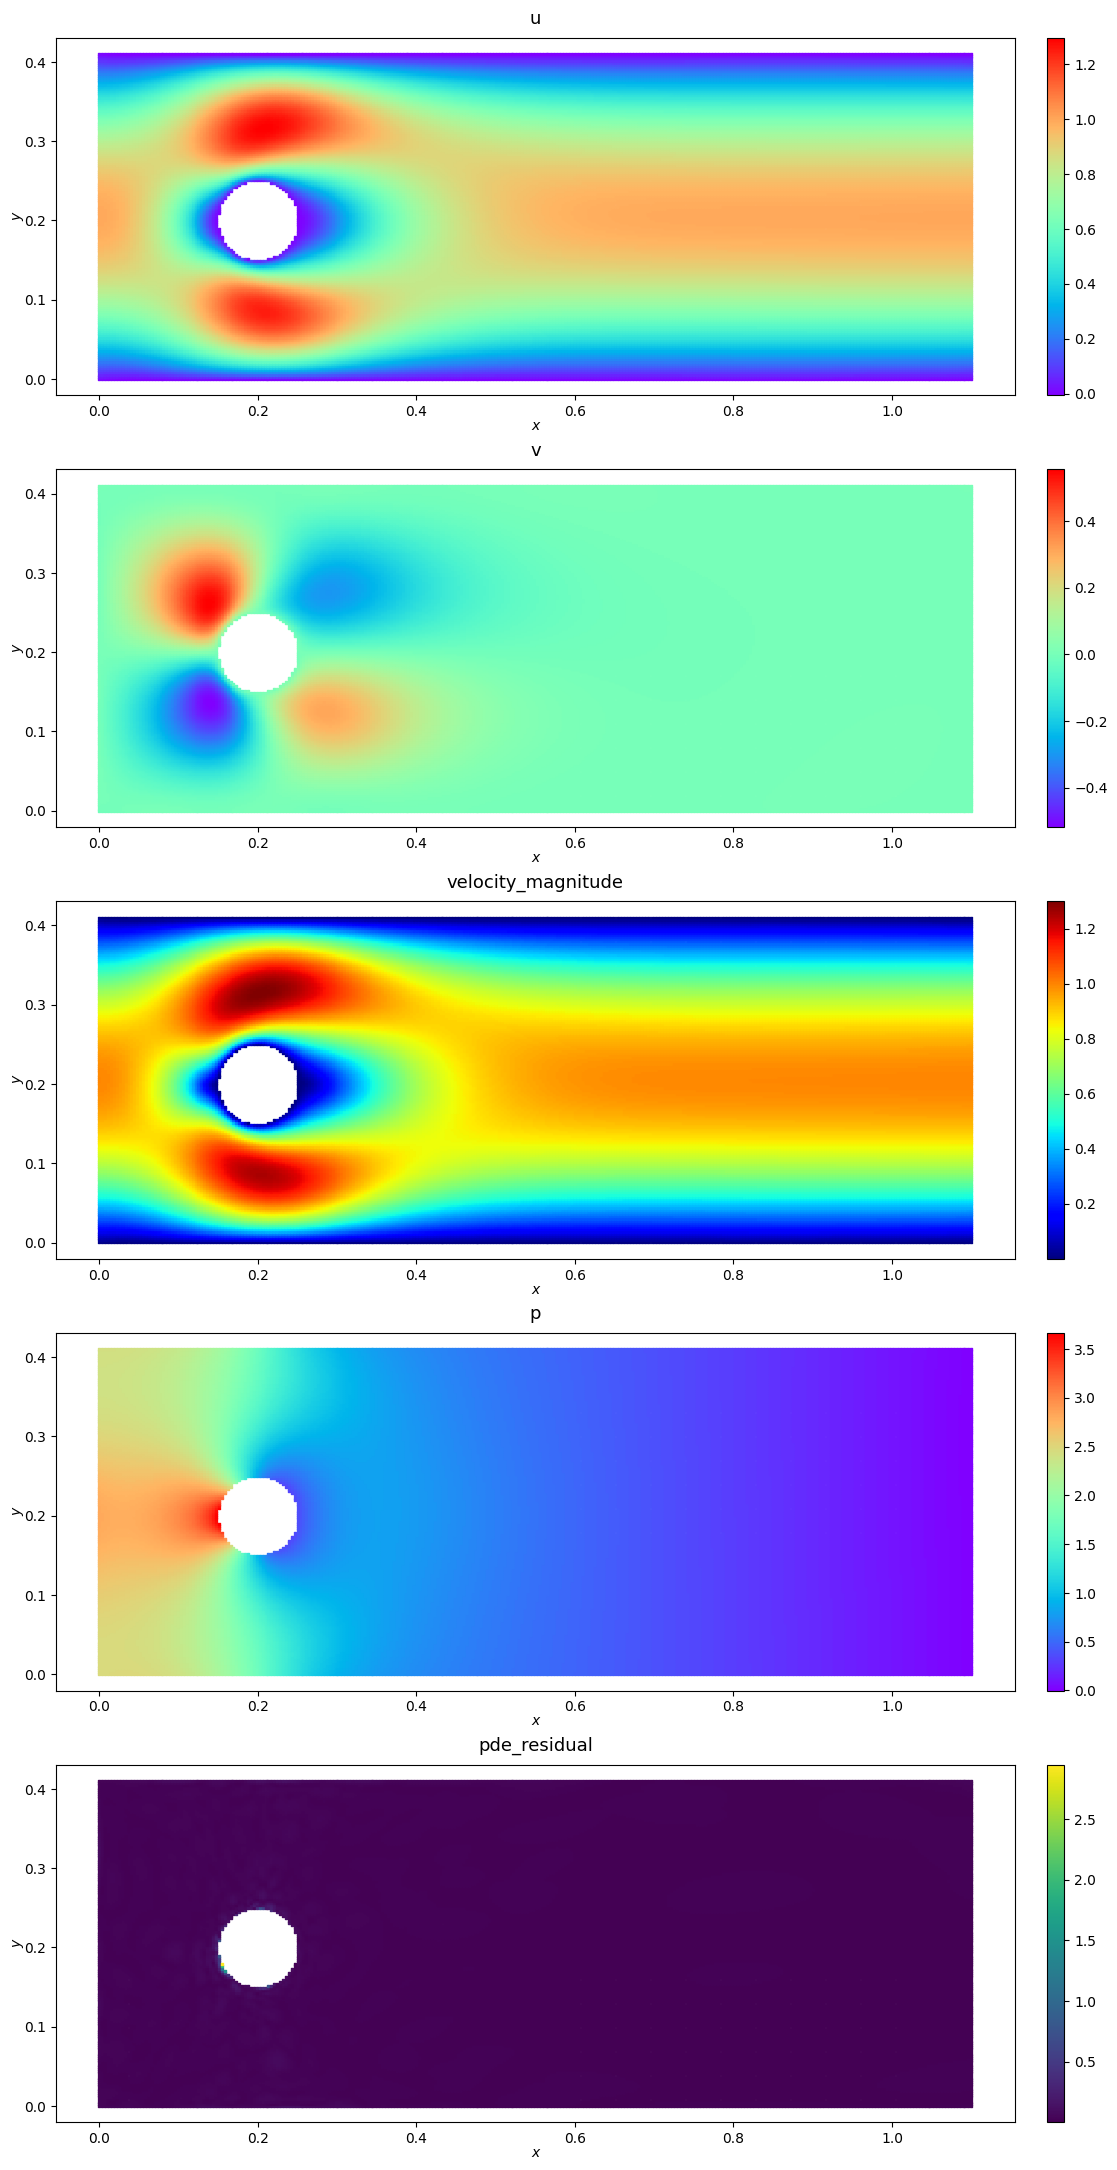

In [13]:
cmap_dict = {
    'u':'rainbow',
    'v':'rainbow',
    'velocity_magnitude': 'jet',
    'p':'rainbow',
    'pde_residual': 'viridis'}
colorplot_area_2d = area_eval.plot_color(cmap_dict, s=2).savefig("colorplot_2d")

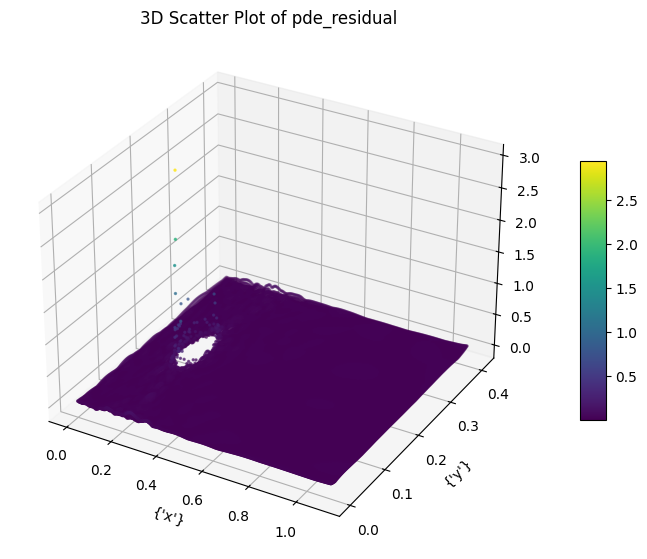

In [14]:
residual_plot_3d = area_eval.plot('pde_residual').savefig("residual_plot_3d.png")

### 4.2 Visualize bound

In [15]:
# Create object for evaluation
bound_visual = domain.bound_list[2].evaluate(model2)
# Sampling uniform points
bound_visual.sampling_line(100)

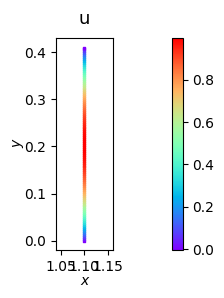

In [16]:
colorplot_bound = bound_visual.plot_color({'u':'rainbow'}).savefig("colorplot_bound.png")

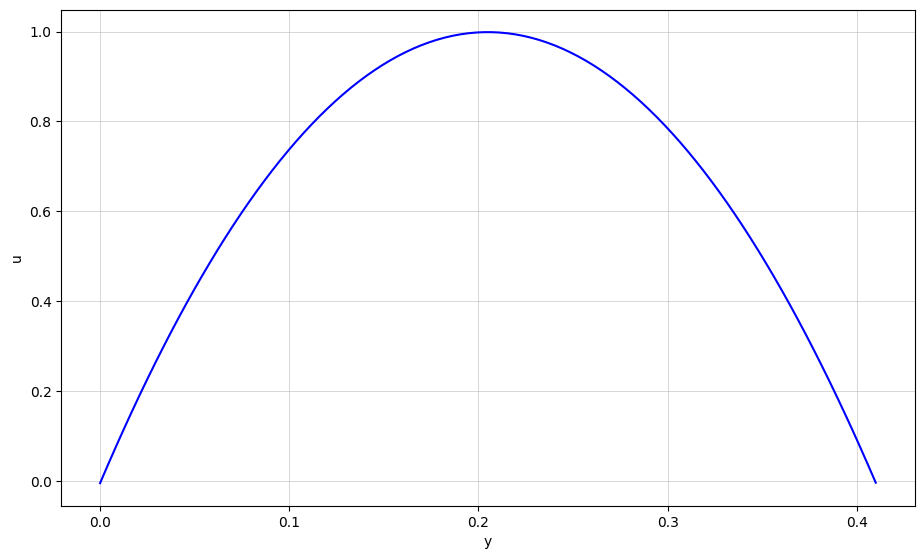

In [17]:
velocity_plot_outlet = bound_visual.plot(x_axis = 'y', y_axis={'u':'blue'})

## 4.3 Visualize Neural Network data

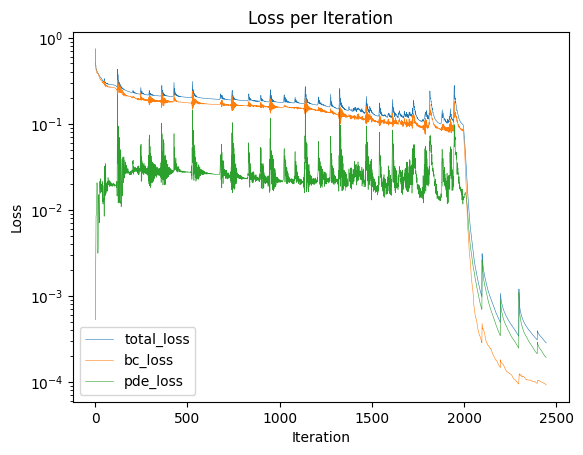

In [18]:
loss_history = bound_visual.plot_loss_curve(log_scale=True, linewidth=0.4).savefig("loss_history.png")

### 4.4 Export data

In [19]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
u_data = bound_visual.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)